In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

sys.path.append('../../benchmarks_unknown/')
from benchmark_functions import DejongConstr, AckleyPathConstr, BraninConstr, HyperEllipsoidConstr, LevyConstr
from benchmark_functions import MichalewiczConstr, RastriginConstr, SchwefelConstr, StyblinskiTangConstr
from benchmark_functions import DiscreteAckleyConstr, DiscreteDoubleWellConstr, DiscreteMichalewiczConstr
from benchmark_functions import LinearFunnelConstr, NarrowFunnelConstr

sns.set(style='ticks', context='notebook', font_scale=1.2)

In [2]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
plt.register_cmap(cmap=_cmap)
plt.register_cmap(cmap=_cmap_r)

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='golem'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_surface(surface, ax=None, N=100, fs=10, fmt='%d', nlines=8):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=fs, labels_fmt=fmt, n_contour_lines=nlines, contour_alpha=0.8, cbar=False, cmap='golem')
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)

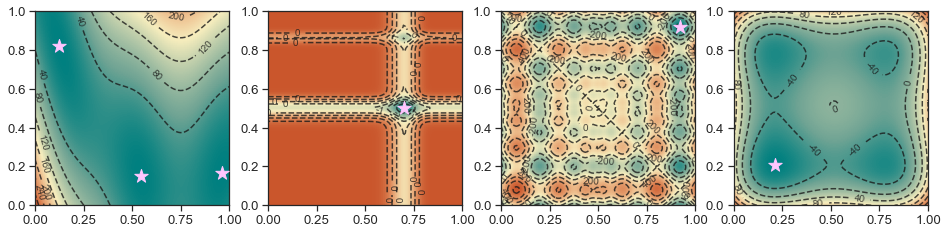

In [3]:
from olympus.surfaces import Surface

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

surface1 = Surface(kind='Branin', param_dim=2)
surface2 = Surface(kind='Michalewicz', param_dim=2)
surface3 = Surface(kind='Schwefel', param_dim=2)
surface4 = Surface(kind='StyblinskiTang', param_dim=2)

plot_surface(surface1, ax=axes[0], N=100)
plot_surface(surface2, ax=axes[1], N=100)
plot_surface(surface3, ax=axes[2], N=100)
plot_surface(surface4, ax=axes[3], N=100)

In [4]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)

def plot_min_trace_mean(data, ax=None, color=None, label=None, categorical=False, shift=0.0):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    if categorical is True:
        traces_min = get_traces_min_for_categorical(data) - shift
    else:
        traces_min = get_traces_min(data) - shift
    
    mean = np.nanmean(traces_min, axis=0)
    stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=5)
    ax.plot(x, mean, color=color, linewidth=4, label=label)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)
    
def plot_min_trace_median(data, ax=None, color=None, label=None, nboots=1000):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    traces_min = get_traces_min(data, replace_nan=True)

    median = np.median(traces_min, axis=0)
    q100, q75, q25, q0 = bootstrapped_iqr(traces_min, nboots=1000)
    x = range(1, np.shape(traces_min)[1] + 1, 1)

    ax.plot(x, median, color=color, label=label)
    ax.fill_between(x, y1=q25, y2=q75, alpha=0.2, color=color)
    ax.fill_between(x, y1=q0, y2=q100, alpha=0.2, color=color)
    
    
def bootstrapped_iqr(traces, nboots=100):
    boot_medians = []
    for b in range(nboots):
        boot_idx = np.random.randint(low=0, high=traces.shape[0], size=traces.shape[0])
        boot_traces = traces[boot_idx]
        boot_median = np.median(boot_traces, axis=0)
        boot_medians.append(boot_median)
        
    q75, q25 = np.percentile(np.array(boot_medians), [75 ,25], axis=0)
    q100 = np.max(traces, axis=0)
    q0 = np.min(traces, axis=0)
    return q100, q75, q25, q0


def plot_trace_sigle(folder, ax, categorical=False, color='k', label='', shift=0.0):
    with open(f'{folder}/results.pkl', 'rb') as content:
        data = pickle.load(content)
    plot_min_trace_mean(data, ax=ax, color=color, label=label, categorical=categorical, shift=shift)

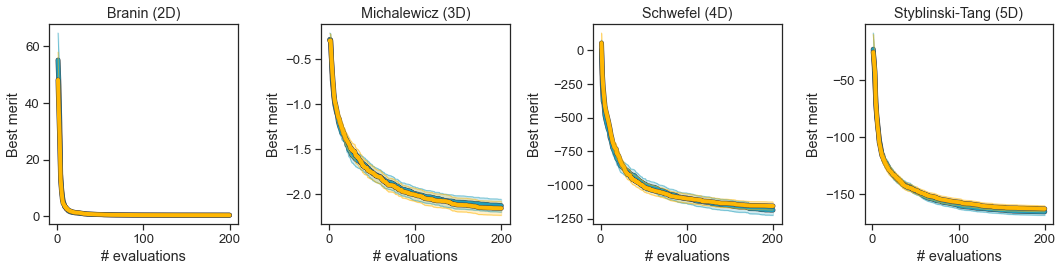

In [5]:
def plot_trace_comparison(folder, ax):
    
    with open(f'{folder}/opt_adam/results.pkl', 'rb') as content:
        data_adam = pickle.load(content)
    with open(f'{folder}/opt_genetic/results.pkl', 'rb') as content:
        data_gene = pickle.load(content)

    plot_min_trace_mean(data_adam, ax=ax, color='#219ebc', label='Gryffin (Adam)')
    plot_min_trace_mean(data_gene, ax=ax, color='#ffb703', label='Gryffin (Genetic)')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))

plot_trace_comparison('../../benchmarks_optimizers/branin_2d', axes[0])
plot_trace_comparison('../../benchmarks_optimizers/michalewicz_3d/', axes[1])
plot_trace_comparison('../../benchmarks_optimizers/schwefel_4d/', axes[2])
plot_trace_comparison('../../benchmarks_optimizers/styblinski_5d/', axes[3])

for ax in axes:
    ax.set_xlabel('# evaluations')
    ax.set_ylabel('Best merit')
    
axes[0].set_title('Branin (2D)')
axes[1].set_title('Michalewicz (3D)')
axes[2].set_title('Schwefel (4D)')
axes[3].set_title('Styblinski-Tang (5D)')
    
plt.tight_layout()

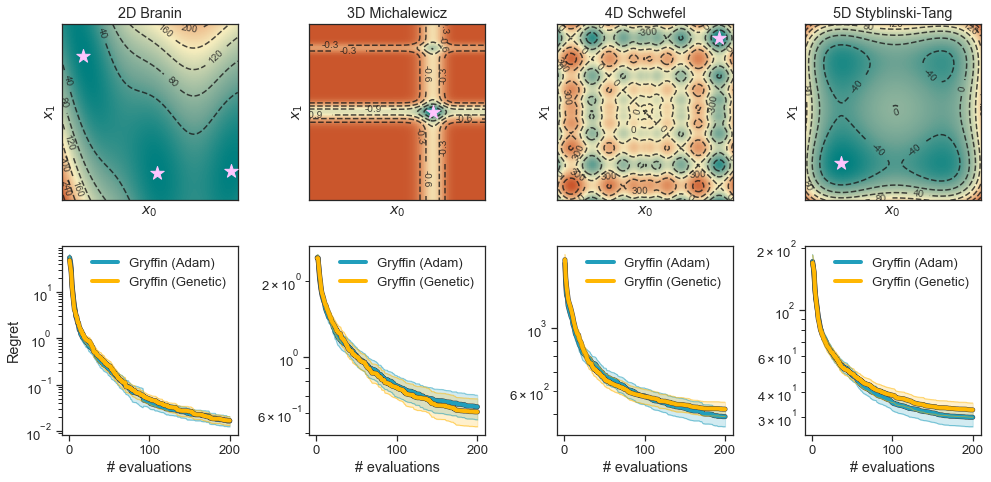

In [6]:
from olympus.surfaces import Surface

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7))

surface1 = Surface(kind='Branin', param_dim=2)
surface2 = Surface(kind='Michalewicz', param_dim=2)
surface3 = Surface(kind='Schwefel', param_dim=2)
surface4 = Surface(kind='StyblinskiTang', param_dim=2)

plot_surface(surface1, ax=axes[0,0], N=100, fs=10, fmt='%d', nlines=8)
plot_surface(surface2, ax=axes[0,1], N=100, fs=10, fmt='%.1f', nlines=5)
plot_surface(surface3, ax=axes[0,2], N=100, fs=10, fmt='%d', nlines=5)
plot_surface(surface4, ax=axes[0,3], N=100, fs=10, fmt='%d', nlines=8)

#plot_trace_comparison('../../benchmarks_optimizers/branin_2d', axes[1,0])
#plot_trace_comparison('../../benchmarks_optimizers/michalewicz_3d/', axes[1,1])
#plot_trace_comparison('../../benchmarks_optimizers/schwefel_4d/', axes[1,2])
#plot_trace_comparison('../../benchmarks_optimizers/styblinski_5d/', axes[1,3])

surface = Surface(kind='Branin', param_dim=2)
plot_trace_sigle('../../benchmarks_optimizers/branin_2d/opt_adam/', axes[1,0], color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_optimizers/branin_2d/opt_genetic/', axes[1,0], color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'])

surface = Surface(kind='Michalewicz', param_dim=3)
plot_trace_sigle('../../benchmarks_optimizers/michalewicz_3d/opt_adam/', axes[1,1], color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_optimizers/michalewicz_3d/opt_genetic/', axes[1,1], color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'])

surface = Surface(kind='Schwefel', param_dim=4)
plot_trace_sigle('../../benchmarks_optimizers/schwefel_4d/opt_adam/', axes[1,2], color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_optimizers/schwefel_4d/opt_genetic/', axes[1,2], color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'])

surface = Surface(kind='StyblinskiTang', param_dim=5)
plot_trace_sigle('../../benchmarks_optimizers/styblinski_5d/opt_adam/', axes[1,3], color='#219ebc', label='Gryffin (Adam)', 
                 shift=surface.minima[0]['value'])
plot_trace_sigle('../../benchmarks_optimizers/styblinski_5d/opt_genetic/', axes[1,3], color='#ffb703', label='Gryffin (Genetic)', 
                 shift=surface.minima[0]['value'])


for j in range(4):
    axes[1,j].set_yscale('log')
    axes[0,j].set_ylabel('$x_1$')
    
for ax in axes[0, :]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_0$')
    

axes[1,0].set_ylabel('Regret')
for ax in axes[1,:]:
    ax.set_xlabel('# evaluations')
    
    
axes[0,0].set_title('2D Branin')
axes[0,1].set_title('3D Michalewicz')
axes[0,2].set_title('4D Schwefel')
axes[0,3].set_title('5D Styblinski-Tang')

axes[1,0].legend(frameon=False)
axes[1,1].legend(frameon=False)
axes[1,2].legend(frameon=False)
axes[1,3].legend(frameon=False)
    
plt.tight_layout()
fig.savefig('adam_genetic_comparison.pdf', bbox_inches='tight')
fig.savefig('adam_genetic_comparison.png', dpi=300, bbox_inches="tight")

In [17]:
surface = Surface(kind='Schwefel', param_dim=4)
surface.minima

[{'params': [0.9209687, 0.9209687, 0.9209687, 0.9209687],
  'value': -1675.93154908865}]

In [67]:
def add_subplot_axes(ax,rect):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

def plot_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=6, contour_alpha=0.8, cbar=False, cmap='golem')
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=100, marker='*', color='white', zorder=20)

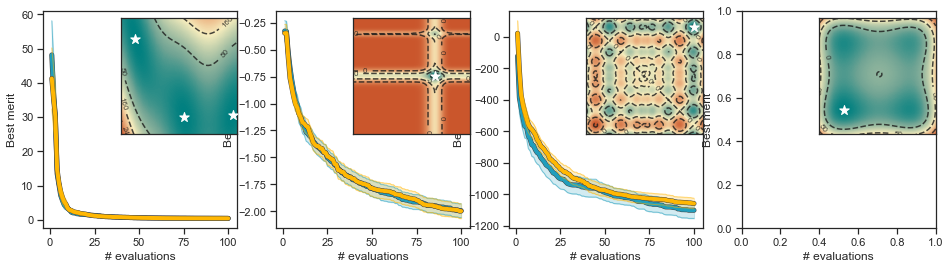

In [71]:
from olympus.surfaces import Surface

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

plot_trace_comparison('../../benchmarks_optimizers/branin_2d', axes[0])
plot_trace_comparison('../../benchmarks_optimizers/michalewicz_3d/', axes[1])
plot_trace_comparison('../../benchmarks_optimizers/schwefel_4d/', axes[2])
#plot_trace_comparison('../../benchmarks_optimizers/styblinski_5d/', axes[3])

# add surfaces
surface1 = Surface(kind='Branin', param_dim=2)
surface2 = Surface(kind='Michalewicz', param_dim=2)
surface3 = Surface(kind='Schwefel', param_dim=2)
surface4 = Surface(kind='StyblinskiTang', param_dim=2)

rect = [0.4, 0.4, 0.6, 0.6]
ax1 = add_subplot_axes(axes[0],rect)
ax2 = add_subplot_axes(axes[1],rect)
ax3 = add_subplot_axes(axes[2],rect)
ax4 = add_subplot_axes(axes[3],rect)
    
plot_surface(surface1, ax=ax1, N=100)
plot_surface(surface2, ax=ax2, N=100)
plot_surface(surface3, ax=ax3, N=100)
plot_surface(surface4, ax=ax4, N=100)

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([])
    ax.set_yticks([])
    
for ax in axes:
    ax.set_xlabel('# evaluations')
    ax.set_ylabel('Best merit')